# SEL634 - Laboratório de Robôs Manipuladores

## Inicialização da biblioteca

Carregar a biblioteca de robótica para Python:

In [1]:
!pip install roboticstoolbox-python
!pip install spatialmath-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.7 MB 5.2 MB/s 
     |████████████████████████████████| 112.2 MB 89 kB/s 
     |████████████████████████████████| 13.5 MB 47.7 MB/s 
     |████████████████████████████████| 1.5 MB 43.4 MB/s 
     |████████████████████████████████| 178 kB 50.8 MB/s 
     |████████████████████████████████| 112 kB 40.9 MB/s 
  Created wheel for ansitable: filename=ansitable-0.9.6-py3-none-any.whl size=12621 sha256=81c3a855f86a19ef3f147e90b357eab17e2e953ae95e98b268b05b7e4d027c85
  Stored in directory: /root/.cache/pip/wheels/57/a4/a9/84ed983596f261a978c880aba60eba145e76aa5a59e455f189
  Created wheel for colored: filename=colored-1.4.3-py3-none-any.whl size=14342 sha256=20326d243770cc7b35d37fcac652b0929abc64791274f9b17deb454eaaa4cd0f
  Stored in directory: /root/.cache/pip/wheels/4a/f6/00/835e81851bc345428a253721c8bdad0062721dfb861bc6e752
  Created wheel for pgraph-pyth

In [2]:
import numpy as np
#import roboticstoolbox as rtb
from roboticstoolbox import *
from spatialmath import *
from math import pi
import matplotlib.pyplot as plt
from matplotlib import cm
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

# teste
# no Binder utilizar essa linha
#%matplotlib notebook  
# no Colab utilizar essa linha
%matplotlib inline

## Cinemática Direta do Robô Kinova Gen3

O robô Kinova Gen3 pode ser modelado pela seguinte função (ver Tarefa 2):

In [3]:
def kinova_robot(my_name):
  robot = DHRobot(
      [
       # Colocar seu código aqui para completar a descrição do robô
        RevoluteDH(d=-(0.1564+0.1284), alpha=pi/2),
            RevoluteDH(d=-(0.0054+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2104+0.2104), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.0064+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2084+0.1059), alpha=pi/2, offset=pi),
            RevoluteDH(alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.1059+0.0615), alpha=pi, offset=pi)
       ], name=my_name)
  H_B0 = SE3.Rz(0)*SE3(0,0,0)*SE3(0,0,0)*SE3.Rx(pi)
  robot.base = H_B0
  return robot


A pose do efetuador do robô Kinova Gen3 é dada em relação a base, $B$, pela função:

In [4]:
def pose_efetuador(robot, q):
  H_B0 = SE3.Rz(0)*SE3(0,0,0)*SE3(0,0,0)*SE3.Rx(pi)
  H_07 = robot.fkine(q)
  return H_B0*H_07

## Tarefa 3 - Trajetória do Robô no Espaço das Juntas

De modo geral, existem duas formas de descrever trajetórias para um robô manipulador: especificar trajetórias no espaço de configuração, ou especificar trajetórias no espaço da tarefa. 

Nesta experiência serão especificadas as trajetórias no espaço de configuração, ou seja, serão especificadas trajetórias para cada junta do robô, e através da cinemática direta serão calculadas a posição e orientação do efetuador para cada configuração do robô.

Através de um polinômio de quinta ordem é possível obter uma trajetória suave para junta ao definir a posição, velocidade e aceleração inicial e final no intervalo de tempo da trajetória. 

**Polinômio de quinta ordem:** Considere que a junta $i$ possui a seguinte trajetória  em graus no tempo que leva a junta $i$ da posição $\theta_{si}$ até $\theta_{gi}$ em um intervalo de tempo $T_d$:
$$ \theta_i (t) = c_{0i} + c_{1i} t + c_{2i} t^2 + c_{3i} t^3 + c_{4i} t^4 + c_{5i} t^5 $$
Para velocidades e acelerações iniciais e finais iguais a zero, os coeficientes do polinômio são dados em função da posição inicial e final e do intervalo de tempo:
\begin{eqnarray*}
	&c_{0i}& = \theta_{si}\\
	&c_{1i}& = c_{2i} = 0\\
	&c_{3i}& = \frac{10(\theta_{gi}-\theta_{si})}{T_d^{3}}\\
	&c_{4i}& = \frac{15(\theta_{si}-\theta_{gi})}{T_d^{4}}\\
	&c_{5i}& = \frac{6(\theta_{gi}-\theta_{si})}{T_d^{5}}
\end{eqnarray*}

A velocidade de cada junta para condições iniciais nulas é dada por:
$$ \dot\theta_i (t) = c_{1i} + 2c_{2i} t + 3c_{3i} t^2 + 4c_{4i} t^3 + 5c_{5i} t^4 $$

A aceleração de cada junta para condições iniciais nulas é dada por:
$$ \ddot\theta_i (t) = 2c_{2i} + 6c_{3i} t + 12c_{4i} t^2 + 20c_{5i} t^3 $$


### 3.1 **Escreva uma função para calcular a trajetória das juntas do manipulador.** 

**A função deve ter como entrada:** um vetor $\theta_s$ com as posições iniciais das $N$ juntas do manipulador, um vetor $\theta_g$ com as posições finais das $N$ juntas do manipulador, o intervalo de tempo total do movimento $T_d$, o intervalo de tempo entre cada ponto da trajetória $\delta t$. 

**A função deve ter como saída:** uma matriz $\theta$ que descreve a posição de cada junta no tempo, e que possui dimensão $M \times N$, onde $N$ é o número de juntas do manipulador, $M$ é a quantidade de pontos da trajetória de cada junta ($M = T_d / \delta t$); uma matriz $d\theta$ com dimensão $M \times N$ que descreve a velocidade de cada junta no tempo; uma matriz $dd\theta$ com dimensão $M \times N$ que descreve a aceleração de cada junta no tempo. 

**Observação:** Não utilize a derivada numérica discreta para encontrar a velocidade e aceleração. Calcule a velocidade e aceleração a partir das suas funções analíticas. Também não utilize loop para encontrar os pontos das curvas, ao invés disso, crie um vetor de tempo com $M$ elementos de $0$ a $T_d$, e use esse vetor diretamente no calculo das trajetórias. 

In [102]:
def calcular_trajetoria(theta_s, theta_g, Td, dt):
  # Coloque seu codigo aqui
    M = theta_s.size # Array length
    
    c0 = theta_s
    c1 = np.zeros(M)
    c2 = c1
    c3 = 10*(theta_g-theta_s)/Td**3
    c4 = 15*(theta_s-theta_g)/Td**4
    c5 = 6*(theta_g-theta_s)/Td**5
    
    #print(c1)

    start = 0
    step = dt
    end = Td+step
    t = np.arange(start,end,step)
    t2 = np.power(t,2)
    t3 = np.power(t,3)
    t4 = np.power(t,4)
    t5 = np.power(t,5)
    
    N = len(t)
    #print(c3)
    
    tVec = np.tile(t,(M,1))
    tVec2 = np.tile(t2,(M,1))
    tVec3 = np.tile(t3,(M,1))
    tVec4 = np.tile(t4,(M,1))
    tVec5 = np.tile(t5,(M,1))
    
    onesVec = np.ones((M,N))
    
    #print(tVec5)
    #print("M =",M)
    #print(tVec*c1[:,np.newaxis])
    
    theta_t = onesVec*c0[:,np.newaxis] + tVec*c1[:,np.newaxis] + tVec2*c2[:,np.newaxis] + tVec3*c3[:,np.newaxis] + tVec4*c4[:,np.newaxis] + tVec5*c5[:,np.newaxis]
    dtheta_t = onesVec*c1[:,np.newaxis] + 2*tVec*c2[:,np.newaxis] + 3*tVec2*c3[:,np.newaxis] + 4*tVec3*c4[:,np.newaxis] + 5*tVec4*c5[:,np.newaxis]
    ddtheta_t = 2*onesVec*c2[:,np.newaxis] + 2*3*tVec*c3[:,np.newaxis] + 3*4*tVec2*c4[:,np.newaxis]+4*5*tVec3*c5[:,np.newaxis]
    return theta_t, dtheta_t, ddtheta_t

# Testing the function
theta_s = np.array([1,2])
theta_g = np.array([2,3])
Td = 1
dt = 0.1
[theta1, theta2, theta3] = calcular_trajetoria(theta_s,theta_g,Td,dt)
print(theta1)

[[       1    1.009    1.058    1.163    1.317      1.5    1.683    1.837    1.942    1.991
         2]
 [       2    2.009    2.058    2.163    2.317      2.5    2.683    2.837    2.942    2.991
         3]]


### 3.2 Escreva uma função para plotar as curvas de posição, velocidade e aceleração em função do tempo para cada junta do robô. 

O programa deve plotar 3 gráficos em função do tempo, um para a posição, um para velocidade e um para aceleração nas juntas. Em cada um dos três gráficos, sobreponha as curvas para as juntas do robô identificando por cores diferentes cada uma das juntas. Não esqueça de colocar título nas figuras, rótulo para cada um dos eixos com a unidade de medida e significado, e legenda para as cores. 

**Entrada da função:** As mesmas entradas da função do item 3.1. 

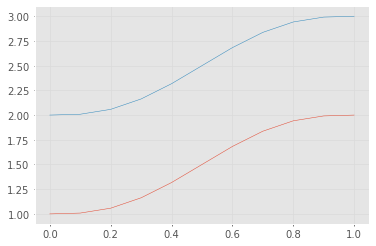

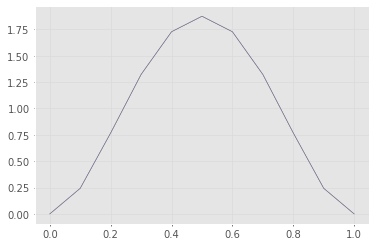

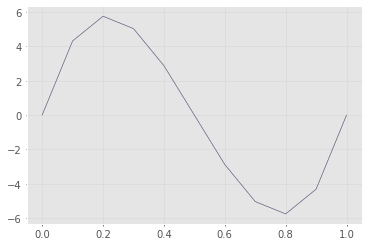

In [123]:
def plotar_trajetoria_juntas(theta_s, theta_g, Td, dt):
  # Coloque seu codigo aqui
    
    # Criar vetor tempo
    start = 0
    step = dt
    end = Td+step
    t = np.arange(start,end,step)
    
    # Obter curvas theta
    [theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
    
    # Construir os gráficos
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(1,1,1)
    for i in range(theta_s.size):
      ax1.plot(t,theta_t[i,:])  # theta
    ax1.grid(True)
    
    fig2 = plt.figure() 
    ax2 = fig2.add_subplot(1,1,1)
    for i in range(theta_s.size):
      ax2.plot(t,dtheta_t[i,:]) # dtheta
    ax2.grid(True)

    fig2 = plt.figure() 
    ax2 = fig2.add_subplot(1,1,1)
    for i in range(theta_s.size):
      ax2.plot(t,ddtheta_t[i,:]) # ddtheta
    ax2.grid(True)

# theta_s = np.array([1,2])
# theta_g = np.array([2,3])
# Td = 1
# dt = 0.1
# plotar_trajetoria_juntas(theta_s,theta_g,Td,dt)

### 3.3 Escreva uma função que calcule a cinemática direta do robô Kinova Gen3 para cada ponto da trajetória do robô no espaço das juntas

Para cada configuração do robô no tempo, $\mathbf{q} = [\theta_1~\theta_2~\theta_3~ \theta_4~ \theta_5~ \theta_6~ \theta_7]^T$, calcular matriz de transformação homogênea que representa a pose do efetuador em relação a base. 

**Entrada da função:** O modelo cinemático do robô Kinova Gen3 (resultado da Tarefa 2); a matriz $\theta$ de dimensão $M \times N$ resultado do item 3.1. 

**Saída da função:** um vetor `np.array` de matrizes de transformação homogênea (dimensão $M \times 4 \times 4$), em que para cada instante de tempo, a matriz de transformação homogênea representa a pose do robô (posição e orientação do efetuador). Consulte a seção 2.5 da tarefa 2.

In [ ]:
def calcular_traj_efetuador(robot, theta_t):
  # Coloque seu codigo aqui

  return HH_efetuador

### 3.4 Escreva um programa para plotar a curva de posição cartesiana do efetuador em função do tempo. 

Essa curva 2D deve apresentar curvas em função do tempo de $x_e$,  $y_e$, e  $z_e$ sobrepostas identificas por cores diferentes. 

**Entrada da função:** um vetor `np.array` de matrizes de transformação homogênea (dimensão $M \times 4 \times 4$), em que para cada instante de tempo, a matriz de transformação homogênea representa a pose do robô (posição e orientação do efetuador); o intervalo de tempo entre cada ponto da trajetória $\delta t$. 

In [ ]:
def plotar_trajetoria_efetuador(HH_efetuador, dt):
  # Coloque seu codigo aqui

### 3.5 Escreva um programa para plotar a curva de orientação do efetuador em função do tempo. 

Essa curva 2D deve apresentar a orientação do efetuador em função do tempo descrita em ângulos de roll, pitch e yaw. Os ângulos de roll, pitch e yaw decem ser mostrados no mesmo gráfico com cores diferentes e claramente identificadas. Para cada instante de tempo, o calculo dos ângulos de roll, pitch e yaw devem ser feitos a partir da matriz de transformação homogênea.

**Entrada da função:** um vetor `np.array` de matrizes de transformação homogênea (dimensão $M \times 4 \times 4$), em que para cada instante de tempo, a matriz de transformação homogênea representa a pose do robô (posição e orientação do efetuador); o intervalo de tempo entre cada ponto da trajetória $\delta t$. 

In [ ]:
def plotar_orientacao_efetuador(HH_efetuador, dt):
  # Coloque seu codigo aqui

### 3.6 Teste das funções

Faça o teste das funções do item 3.2 a 3.5 para os seguintes parâmetros: $T_d = 10$ segundos, $\delta t = 0.01$ segundos,  posição inicial das juntas $\theta_s = [0, 0, 0, 0, 0, 0, 0]^T$  e posição final das juntas $\theta_g = [90, 90, 0, -90, 0, 90, 0]^T$ dada em graus.

In [ ]:
Td = 10.0
dt = 0.01
theta_s = np.array([0,0,0,0,0,0,0])
theta_g = np.array([90,90,0,−90,0,90,0])



# Cinemática Inversa
tarefa 4

Na tarefa 3, a saída era o vetor de poses He do efetuador, dada a trajetória das juntas.
Na tarefa 4, o objetivo é obter a trajetória das juntas dado o vetor de poses He.
Verifique os resultados. Como o manipulador é redundante, a trajetória de juntas calculada pela cinemática inversa pode ser diferente da entrada da tarefa 3.
q0: chute inicial para calcular a cinemática inversa. Podemos utilizar a condição inicial do manipulador, fornecida na tarefa 3.
